In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

import os
from PIL import Image
from IPython.display import display

from torch.utils import data

import cv2
from pathlib import Path
from torch.nn import functional as F

In [2]:
def load_image(path, mask = False):
    img = cv2.imread(str(path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, _ = img.shape

    if height % 32 == 0:
        y_min_pad = 0
        y_max_pad = 0
    else:
        y_pad = 32 - height % 32
        y_min_pad = int(y_pad / 2)
        y_max_pad = y_pad - y_min_pad
    if width % 32 == 0:
        x_min_pad = 0
        x_max_pad = 0
    else:
        x_pad = 32 - width % 32
        x_min_pad = int(x_pad / 2)
        x_max_pad = x_pad - x_min_pad
    
    img = cv2.copyMakeBorder(img, y_min_pad, y_max_pad, x_min_pad, x_max_pad, cv2.BORDER_REFLECT_101)
    if mask:
        img = img[:, :, 0:1] // 255
        return torch.from_numpy(img).float().permute([2, 0, 1])
    else:
        img = img / 255.0
        return torch.from_numpy(img).float().permute([2, 0, 1])

In [3]:
class TGSSaltDataset(data.Dataset):
    def __init__(self, root_path, file_list, is_test = False):
        self.is_test = is_test
        self.root_path = root_path
        self.file_list = file_list
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        if index not in range(0, len(self.file_list)):
            return self.__getitem__(np.random.randint(0, self.__len__()))
        
        file_id = self.file_list[index]
        image_folder = os.path.join(self.root_path, "images")
        image_path = os.path.join(image_folder, file_id + ".png")
        
        mask_folder = os.path.join(self.root_path, "masks")
        mask_path = os.path.join(mask_folder, file_id + ".png")
        
        image = load_image(image_path)
        
        if self.is_test:
            return (image,)
        else:
            mask = load_image(mask_path, mask = True)
            return image, mask
depths_df = pd.read_csv(os.path.join('./', 'train.csv'))

train_path = os.path.join('./', 'train')
file_list = list(depths_df['id'].values)

file_list_val = file_list[::10]
file_list_train = [f for f in file_list if f not in file_list_val]

dataset = TGSSaltDataset(train_path, file_list_train)
dataset_val = TGSSaltDataset(train_path, file_list_val)

In [4]:
train_loader = DataLoader(dataset, batch_size = 30, shuffle = True, pin_memory = True)

In [5]:
class UNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, (1,1))
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 16, 3, 1, (1,1))
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, 1, (1,1))
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 32, 3, 1, (1,1))
        self.bn4 = nn.BatchNorm2d(32)
        self.conv5 = nn.Conv2d(32, 64, 3, 1, (1,1))
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.Conv2d(64, 64, 3, 1, (1,1))
        self.bn6 = nn.BatchNorm2d(64)
        self.conv7 = nn.Conv2d(64, 128, 3, 1, (1,1))
        self.bn7 = nn.BatchNorm2d(128)
        self.conv8 = nn.Conv2d(128, 128, 3, 1, (1,1))
        self.bn8 = nn.BatchNorm2d(128)
        self.conv9 = nn.Conv2d(128, 256, 3, 1, (1,1))
        self.bn9 = nn.BatchNorm2d(256)
        self.conv10 = nn.Conv2d(256, 256, 3, 1, (1,1))
        self.bn10 = nn.BatchNorm2d(256)
        self.tconv1 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.conv11 = nn.Conv2d(256, 128, 3, 1, (1,1))
        self.bn11 = nn.BatchNorm2d(128)
        self.conv12 = nn.Conv2d(128, 128, 3, 1, (1,1))
        self.bn12 = nn.BatchNorm2d(128)
        self.tconv2 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.conv13 = nn.Conv2d(128, 64, 3, 1, (1,1))
        self.bn13 = nn.BatchNorm2d(64)
        self.conv14 = nn.Conv2d(64, 64, 3, 1, (1,1))
        self.bn14 = nn.BatchNorm2d(64)
        self.tconv3 = nn.ConvTranspose2d(64, 32, 2, 2)
        self.conv15 = nn.Conv2d(64, 32, 3, 1, (1,1))
        self.bn15 = nn.BatchNorm2d(32)
        self.conv16 = nn.Conv2d(32, 32, 3, 1, (1,1))
        self.bn16 = nn.BatchNorm2d(32)
        self.tconv4 = nn.ConvTranspose2d(32, 16, 2, 2)
        self.conv17 = nn.Conv2d(32, 16, 3, 1, (1,1))
        self.bn17 = nn.BatchNorm2d(16)
        self.conv18 = nn.Conv2d(16, 16, 3, 1, (1,1))
        self.bn18 = nn.BatchNorm2d(16)
        self.conv19 = nn.Conv2d(16, 1, 1, 1)
        self.bn19 = nn.BatchNorm2d(1)
    def forward(self, X):
        c1 = self.conv1(X)
        c1 = self.bn1(c1)
        c1 = F.relu(c1)
        c1 = self.conv2(c1)
        c1 = self.bn2(c1)
        c1 = F.relu(c1)
        p1 = F.max_pool2d(c1, 2, 2)
        c2 = self.conv3(p1)
        c2 = self.bn3(c2)
        c2 = F.relu(c2)
        c2 = self.conv4(c2)
        c2 = self.bn4(c2)
        c2 = F.relu(c2)
        p2 = F.max_pool2d(c2, 2, 2)
        c3 = self.conv5(p2)
        c3 = self.bn5(c3)
        c3 = F.relu(c3)
        c3 = self.conv6(c3)
        c3 = self.bn6(c3)
        c3 = F.relu(c3)
        p3 = F.max_pool2d(c3, 2, 2)
        c4 = self.conv7(p3)
        c4 = self.bn7(c4)
        c4 = F.relu(c4)
        c4 = self.conv8(c4)
        c4 = self.bn8(c4)
        c4 = F.relu(c4)
        p4 = F.max_pool2d(c4, 2, 2)
        c5 = self.conv9(p4)
        c5 = self.bn9(c5)
        c5 = F.relu(c5)
        c5 = self.conv10(c5)
        c5 = self.bn10(c5)
        c5 = F.relu(c5)
        u6 = self.tconv1(c5)
        u6 = torch.cat((u6,c4),1)
        c6 = self.conv11(u6)
        c6 = self.bn11(c6)
        c6 = F.relu(c6)
        c6 = self.conv12(c6)
        c6 = self.bn12(c6)
        c6 = F.relu(c6)
        u7 = self.tconv2(c6)
        u7 = torch.cat((u7,c3),1)
        c7 = self.conv13(u7)
        c7 = self.bn13(c7)
        c7 = F.relu(c7)
        c7 = self.conv14(c7)
        c7 = self.bn14(c7)
        c7 = F.relu(c7)
        u8 = self.tconv3(c7)
        u8 = torch.cat((u8,c2),1)
        c8 = self.conv15(u8)
        c8 = self.bn15(c8)
        c8 = F.relu(c8)
        c8 = self.conv16(c8)
        c8 = self.bn16(c8)
        c8 = F.relu(c8)
        u9 = self.tconv4(c8)
        u9 = torch.cat((u9,c1),1)
        c9 = self.conv17(u9)
        c9 = self.bn17(c9)
        c9 = F.relu(c9)
        c9 = self.conv18(c9)
        c9 = self.bn18(c9)
        c9 = F.relu(c9)
        c10 = self.conv19(c9)
        c10 = self.bn19(c10)
        c10 = torch.sigmoid(c10)
        return c10

In [6]:
model = UNet()
model = model.cuda()

In [7]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [8]:
for image, mask in train_loader:
    break

In [9]:
image.dtype

torch.float32

In [10]:
image.device

device(type='cpu')

In [11]:
torch.cuda.memory_allocated

<function torch.cuda.memory.memory_allocated(device:Union[torch.device, str, NoneType, int]=None) -> int>

In [12]:
torch.cuda.memory_allocated()

7823872

In [13]:
import time
start_time = time.time()

epochs = 20

for i in range(epochs):
    
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        X_train = X_train.cuda()
        y_train = y_train.cuda()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if b%60 == 0:
            print(f'epoch {i} batch {b} loss = {loss.item()}')

print(f'Duration: {time.time()-start_time}')

epoch 0 batch 60 loss = 0.480851411819458
epoch 0 batch 120 loss = 0.47809189558029175
epoch 1 batch 60 loss = 0.36518165469169617
epoch 1 batch 120 loss = 0.4943777620792389
epoch 2 batch 60 loss = 0.4016927182674408
epoch 2 batch 120 loss = 0.39244553446769714
epoch 3 batch 60 loss = 0.32413250207901
epoch 3 batch 120 loss = 0.3218993544578552
epoch 4 batch 60 loss = 0.30352023243904114
epoch 4 batch 120 loss = 0.3189472258090973
epoch 5 batch 60 loss = 0.2604334354400635
epoch 5 batch 120 loss = 0.29663246870040894
epoch 6 batch 60 loss = 0.2581724524497986
epoch 6 batch 120 loss = 0.22351184487342834
epoch 7 batch 60 loss = 0.3163340389728546
epoch 7 batch 120 loss = 0.32689225673675537
epoch 8 batch 60 loss = 0.2171178162097931
epoch 8 batch 120 loss = 0.32392656803131104
epoch 9 batch 60 loss = 0.32299768924713135
epoch 9 batch 120 loss = 0.26346734166145325
epoch 10 batch 60 loss = 0.23644137382507324
epoch 10 batch 120 loss = 0.18690019845962524
epoch 11 batch 60 loss = 0.19335

In [14]:
y_test = model(image.cuda())

In [15]:
y_test.shape

torch.Size([30, 1, 128, 128])

In [16]:
mask.shape

torch.Size([30, 1, 128, 128])

In [17]:
y_test = y_test[1]

In [18]:
mask = mask[1]

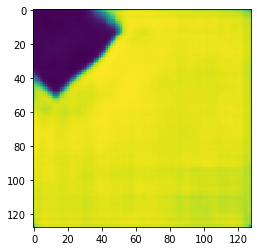

In [27]:
plt.imshow((y_test.cpu().permute(1, 2, 0).detach().numpy().reshape(128,128)))

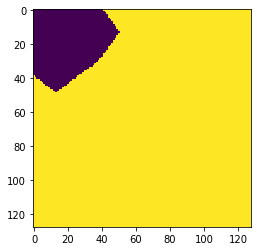

In [28]:
plt.imshow((mask.cpu().permute(1, 2, 0).detach().numpy().reshape(128,128)))

In [29]:
for image, mask in train_loader:
    break

In [30]:
y_test = model(image.cuda())

In [31]:
y1 = y_test[23]

In [32]:
m1 = mask[23]

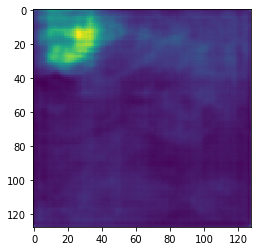

In [33]:
plt.imshow((y1.cpu().permute(1, 2, 0).detach().numpy().reshape(128,128)))

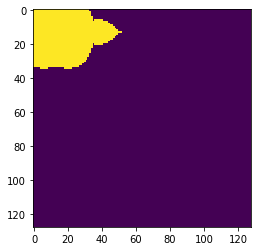

In [34]:
plt.imshow((m1.cpu().permute(1, 2, 0).detach().numpy().reshape(128,128)))

In [35]:
y2 = y_test[14]

In [36]:
m2 = mask[14]

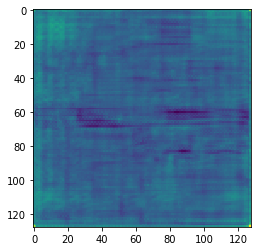

In [37]:
plt.imshow((y2.cpu().permute(1, 2, 0).detach().numpy().reshape(128,128)))

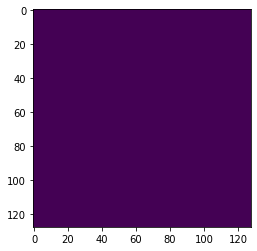

In [38]:
plt.imshow((m2.cpu().permute(1, 2, 0).detach().numpy().reshape(128,128)))

In [39]:
y3 = y_test[4]

In [40]:
m3 = mask[4]

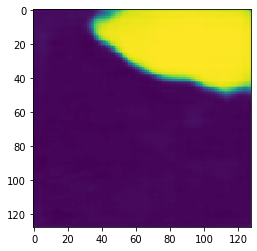

In [41]:
plt.imshow((y3.cpu().permute(1, 2, 0).detach().numpy().reshape(128,128)))

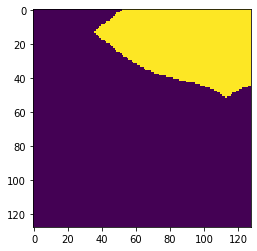

In [42]:
plt.imshow((m3.cpu().permute(1, 2, 0).detach().numpy().reshape(128,128)))